# Module 3 Sprint 2 project - Stroke Prediction

Imagine that you are a data analyst working for The Johns Hopkins Hospital. Your team is asked to create a machine learning model, which could predict if the patient is likely to get a stroke - being able to determine which patients have high stroke risk will allow your doctors to advise them and their families on how to act in case of an emergency.

EDA on the dataset will be performed identifying distributions, population statistics and correlations of features. Following hypohtesis will be checked:

- There is statistically significant relationship between residence type and stroke occurance in patients
- There is statistically significant relationship between gender and stroke occurance in patients

Baseline model will be set to Logistic Regression classifier with additional Random Forest,XGBoost and LightGBM classifiers tested and assessed for best performance.

In order to have a classifier that is functional and helpful we need to establish the metrics by which the models will be evaluated. Choose a metric that would maximise the recall and classify all possible patients as being in risk zone and the workload for the doctors becomes unmanagable. Choose the most precise model and most of the patients will be left identified as risk-free which might not be the case.

The metric used for classification algorithm model selection and further tuning is Average Precision, which summarizes the precission-recall curve and provides average weighted precision at each threshold. Final model will be set with the threshold maximising F1 score on the label were are interested 'stroke'= 1. 
Decision to use this pair of metrics was made to avoid models using default 0.5 threshold value and missing the best possible F1 score when doing the RandomGrid search cross validation. 



Modules and local functions


In [1]:
import sys
import os

sys.path.append("src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import chi2_contingency, ttest_ind, shapiro
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from phik import resources, report
from phik.report import plot_correlation_matrix
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix

from sklego.meta import Thresholder
import shap
from sklearn.metrics import average_precision_score
import plots as plot

Glogabl settings

In [2]:
scoring = "average_precision"
random_state = 42
sns.set_style("whitegrid")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
np.set_printoptions(suppress=True)

Import the dataset

In [5]:
data = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(data)

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Dataset features

1. __id__: unique identifier
2. __gender__: "Male", "Female" or "Other"
3. __age__: age of the patient
4. __hypertension__: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. __heart_disease__: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. __ever_married__: "No" or "Yes"
7. __work_type__: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. __Residence_type__: "Rural" or "Urban"
9. __avg_glucose_level__: average glucose level in blood
10. __bmi__: body mass index
11. __smoking_status__: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. __stroke__: 1 if the patient had a stroke or 0 if not

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


We will drop the id column and use pandas indexing

In [8]:
df = df.drop("id", axis=1)

The dataset is composed of 5110 observation with 12 features each - 9 categorical and 3 numerical

201 missing values


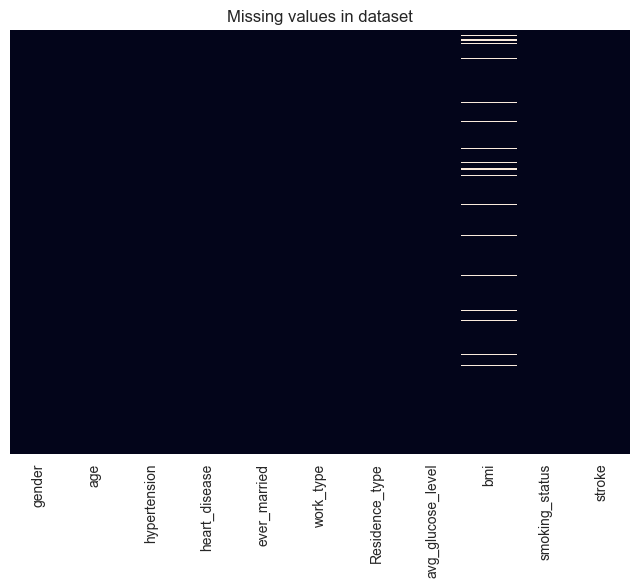

In [9]:
ax = sns.heatmap(df.isnull(), cbar=False)
ax.axes.get_yaxis().set_visible(False)
plt.title("Missing values in dataset")

print(f"{df.isnull().sum().sum()} missing values")

There is a total of 201 values of BMI missing from the dataset, we will try several techniques of imputation for the machine learning models to choose from. We will also take the observations with missing 'bmi' values and check if there are any patterns in these missing observations, this might help deciding on the imputation method.

In [10]:
missing_df = df[df["bmi"].isnull()]

For categorical features lets check the cardinality to see if we can use one hot encoder or some sort of binning will be required

In [11]:
categorical_clm = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
numerical_clm = [
    "age",
    "avg_glucose_level",
    "bmi",
]

In [12]:
df[categorical_clm].nunique()

gender            3
hypertension      2
heart_disease     2
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

Seems fine, the categorical feature with highest cardinality is 'work_type' with 5 categories. Gender has 3 categories so lets have a look at what are the numbers there

In [13]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

We see one observation with gender entered as Other. We will drop the value

In [14]:
df = df.drop((df.loc[df["gender"] == "Other"]).index)

## EDA


Lets start with the most important - target feature 'stroke'.

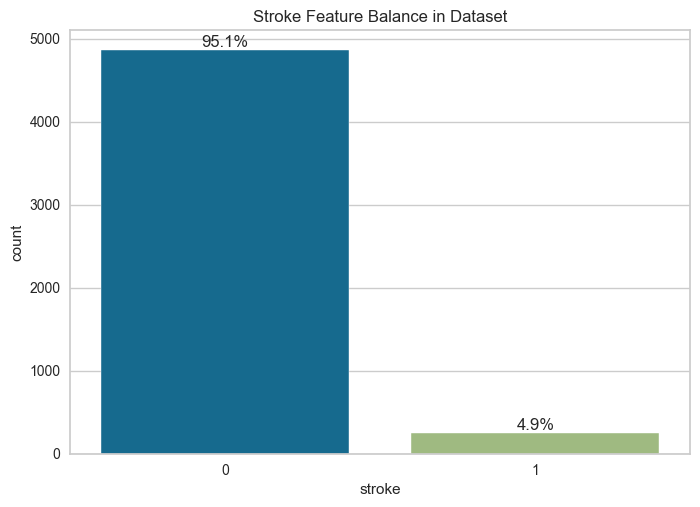

In [15]:
ax = sns.countplot(df, x="stroke")
ax.set_title("Stroke Feature Balance in Dataset")
for c in ax.containers:
    ax.bar_label(c, fmt=lambda v: f"{(v/len(df))*100:0.1f}%")

A very clear imbalance in the dataset can be observed, the positive class for stroke is only accounting for 4.9% of all observations. This has to be taken into account when choosing classification metrics, splitting datasets with stratification and performing k-fold validation. Potential fix to this issue could be undersampling of majority class or synthetic upsampling of minority class.

Lets have an overview of all categorical features present in the dataset, we will apply 'stroke' feature as hue and see if we can spot any obvious tendencies in the categorical analysis that can additionally checked using statistical hypothesis testing tools.

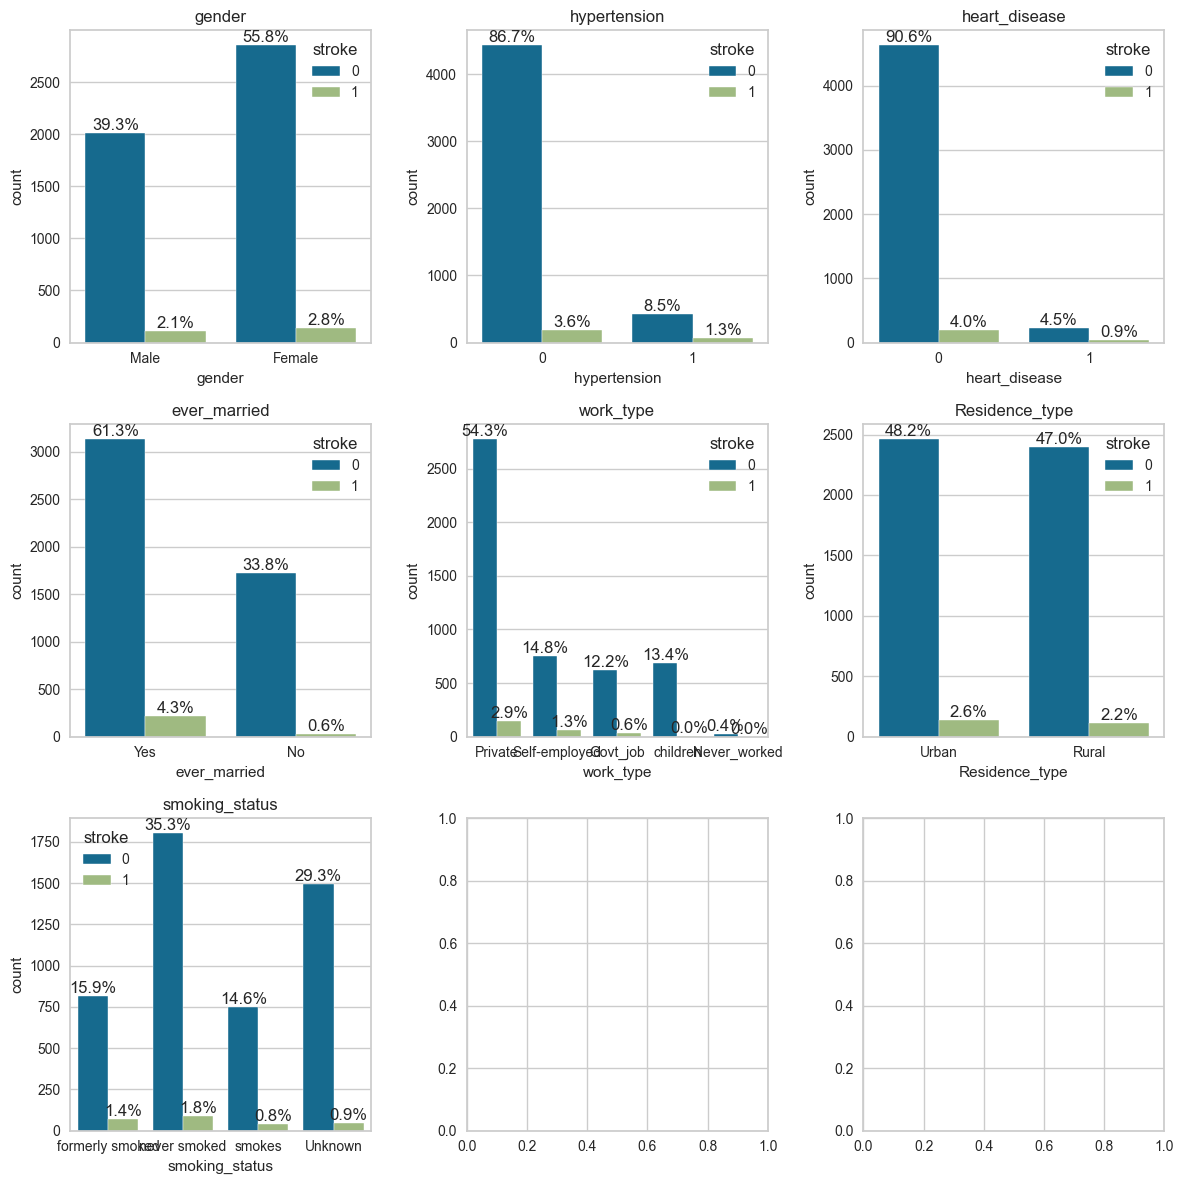

In [16]:
plot.plot_clm(df, categorical_clm)

Just looking at the ratios of features with stroke hue applied there are no obvious signs of what could be key factor in stroke condition. Interestingly presence hypertension (high blood pressure) and heart diseases have lower share of stroke condition among patients.

Next lets have a look at the numerical features and distributions

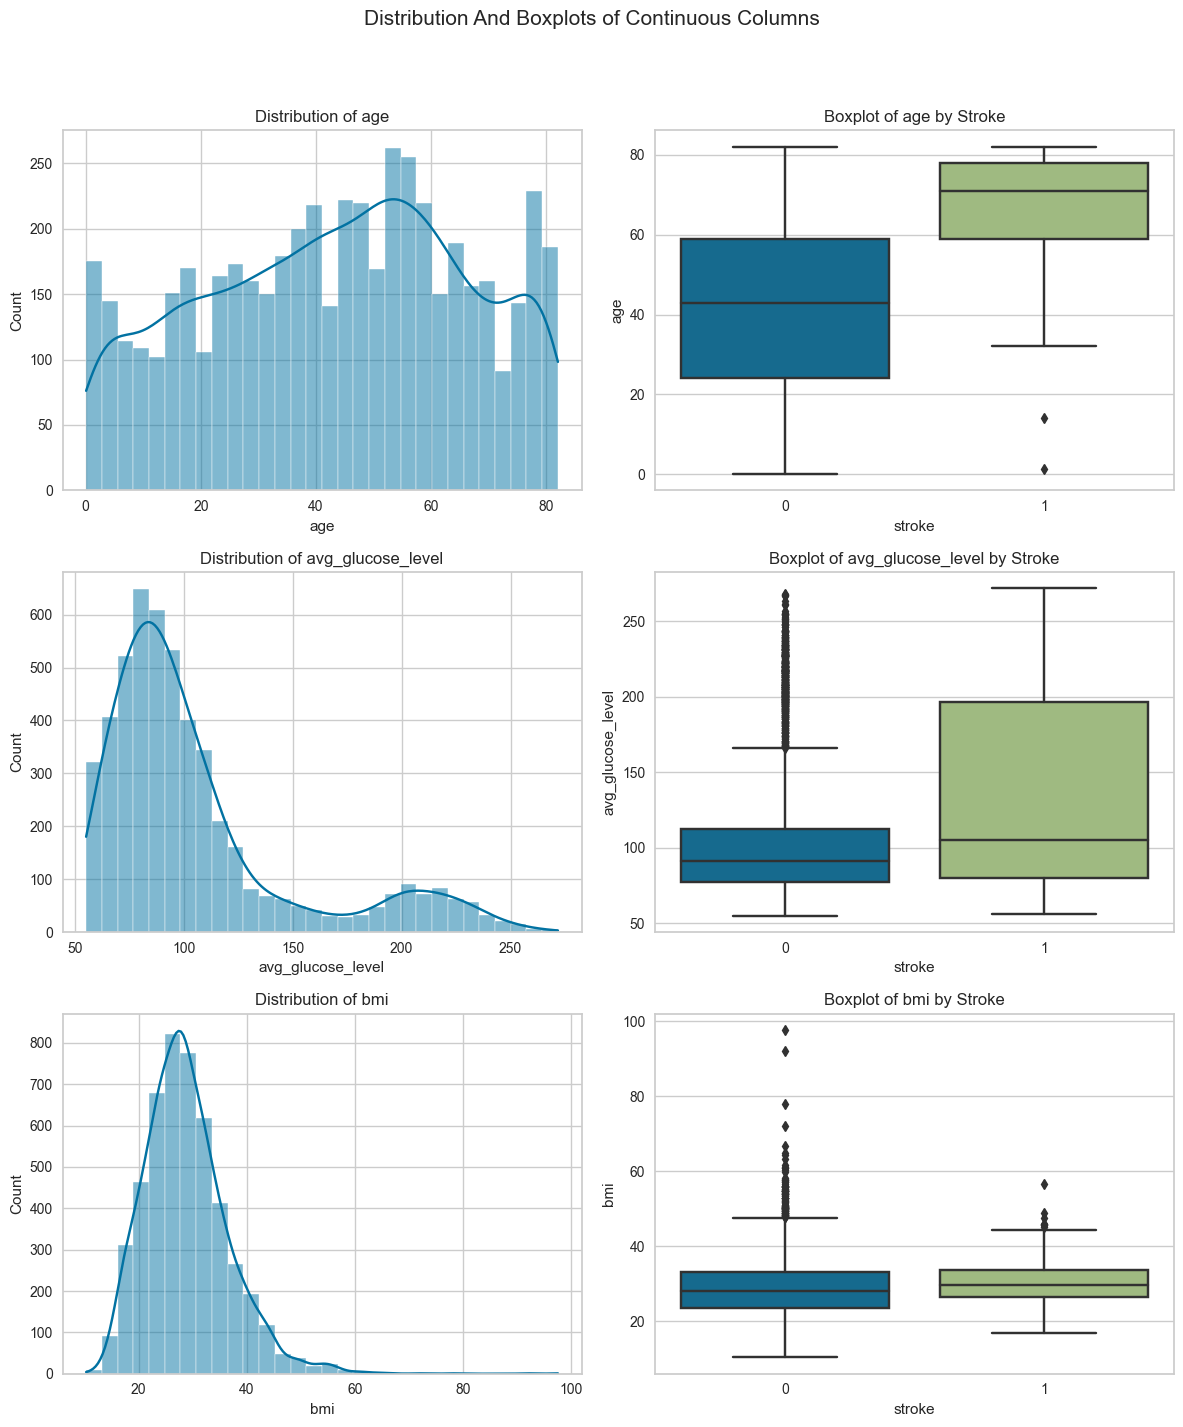

In [17]:
plot.plot_numerical(df, numerical_clm)

In [18]:
print(f"Mean age of observed patients: {df['age'].mean():.0f}")
print(f"Mean BMI of observed patients: {df['bmi'].mean():.2f}")
print(
    f"Average glucose level of observed patients: {df['avg_glucose_level'].mode()[0]}"
)

Mean age of observed patients: 43
Mean BMI of observed patients: 28.89
Average glucose level of observed patients: 93.88


Some observations from  the data visuals above

- Age boxplot shows a significantly higher median age for patients who experienced stroke,with very few outliers on the lower end of the age values. This can be explained by natural deterioration of vascular system and the tendency for failures. The lower end observation can seem odd, but newborns and kids with birth trauma can suffer strokes and it is not a totally uncommon occurrence.

- The shape of avg glucose level might indicate that some patients are diabetic as borderline value of avg_glucose_level in blood is 126 mg/dL. Diabetes is known to increase the cause of stroke. This can be observed in the avg_glucose_level boxplot with a much wider interquantile range for patients who have suffered a stroke.

- BMI follows a normal distribution with mean value of 28.9 which by the classification of World Health Organization is classified as pre-obese for adults. Extra weight and diabetes (high avg glucose level) quite often are correlated, we will check with to see if there is any clear correlation in the observations.

Lets also have a look at the missing bmi values observations. First the ratio of the target feature

In [19]:
missing_df["stroke"].value_counts(normalize=True)

stroke
0    0.800995
1    0.199005
Name: proportion, dtype: float64

The proportion of patients with stroke condition is almost 4x higher than in the whole dataset

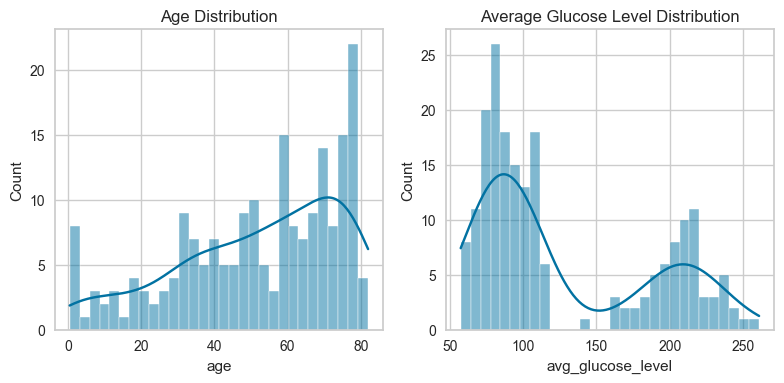

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(missing_df["age"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Age Distribution")

sns.histplot(missing_df["avg_glucose_level"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Average Glucose Level Distribution")

plt.tight_layout()

Numerical features don't show any clear group that would be missing the bmi values for a reason, the age distribution is skewed to the left with more observations on the higher age brackets. Average glucose level distribution looks fairly similar

### Feature correlation

We have a mix of categorical and continuous numerical values in the dataset, to effectively check the corelation between features we will utilize phiK library. To effectively use the library interval columns need to be specified

In [21]:
interval_col = ["age", "avg_glucose_level", "bmi"]

In [22]:
phik_overview = df.phik_matrix(interval_cols=interval_col)

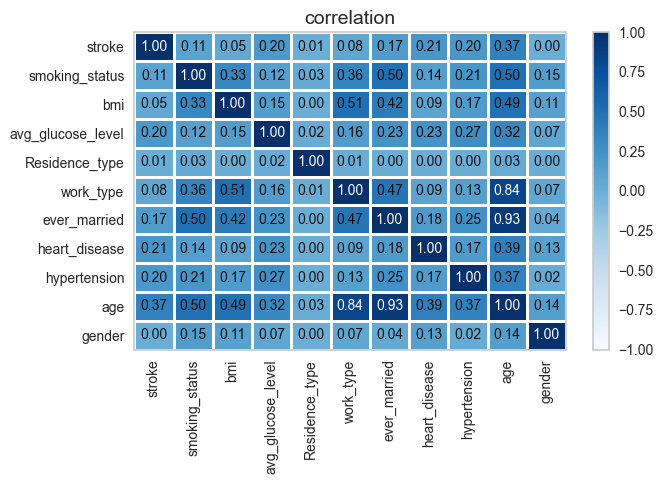

In [23]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    color_map="Blues",
)

We can see a few pairs of highly correlated (>0.7) features, it seems both 'ever_married' and 'work_type' are highly correlated to 'age'. Taking a minute to think about it, it does make sense as it is not specified how the marriage status was recorded so [married,divorced,married twice] would all most likely result in feature ever married value to be positive and the probability of those events increase with time, in this case age. Work_type has values ['children','never_worked'] which again follows the same logic- no one can stay child while getting older and probability of never having a job decreases with time. 

These observations raise some concerns that there is lack of clarity with data and these aggregations can make the classification task quite difficult.

It does seem that there are no obvious correlations with our target 'stroke' feature. 

## Hypothesis testing

To build our understanding of features further we will answer the following questions using hypothesis testing:

- Is there a statistically significant relationship between the Residence type (Urban/Rural) and the presence of a stroke patients?
- Is there a statistically significant relationship between gender and the presence of a stroke in patients?

#### Hypothesis 1

- H0 There is no statistically significant relationship between residence type and stroke occurrence

Alternate hypothesis H1 - There is statistically significant relationship between residence type and stroke occurrence 

We will check the hypothesis using Chi2 test, the following assumptions for the test are met:

- Both variables are categorical: for both cases the variables are categorical (Rural/Urban and 1/0)
- All observations are independent: since the dataset is assembled from historical medical observations it is reasonable to assume that each observation was not influenced by other. 1 record - one set of independent observations
- Cells in the contingency table are mutually exclusive: an individual observation cannot belong to more than one cell. In this case each observation is treated as a one off event with no repeated observations of the same sample.
- Expected value of cells should be 5 or greater in 80% of the cells: as seen from contingency tables that is the case

In [24]:
cont_table = pd.crosstab(df["Residence_type"], df["stroke"])
chi2, p, _, _ = chi2_contingency(cont_table)
print(cont_table)
print(f"\n P-value for the Chi2 test: {p:.2f}")

stroke             0    1
Residence_type           
Rural           2399  114
Urban           2461  135

 P-value for the Chi2 test: 0.30


With the observed P value of 0.3 we cannot reject the null hypothesis and can infer that there is no significant relationship between residence type and stroke occurrence in patients.

#### Hypothesis 2

- H0 there is no statistically significant relationship between gender and the presence of a stroke in patients

Alternate hypothesis H1- There is statistically significant relationship between gender and the presence of a stroke in patients

All of the assumptions from first hypothesis check are applicable and hold true

In [25]:
gender_contingency = pd.crosstab(df["gender"], df["stroke"])
chi2_gender, p_gender, _, _ = chi2_contingency(gender_contingency)
print(f"Chi-square Gender: {chi2_gender}, p-value: {p_gender}")

Chi-square Gender: 0.340002536046177, p-value: 0.5598277580669416


With the Chi2 test complete and observed P value of ~0.56 we can infer that there is no statistically significant relationship between gender and stroke occurrences.

## Machine Learning


As already mentioned the chosen metric for model evaluation is average precision. Since we are evaluating an unbalanced dataset with the positive label being important, we will choose the models that perform best throughout all thresholds and we can fine tune the final model to the acceptable threshold to maximize recall and precision.

### Split the dataset

We will split the dataset into training and testing using stratification to maintain the target label balance. Since cross validation will be used, the dataset will not be split into train/validation/test portions

In [26]:
X = df.drop(["stroke"], axis=1)
y = df["stroke"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state, stratify=y
)

#### Pipelines

In [28]:
numerical_transformer = Pipeline(
    [("imputer", SimpleImputer()), ("scaler", StandardScaler())]
)

In [29]:
categorical_tranformer = Pipeline([("encoder", OneHotEncoder())])

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_clm),
        ("cat", categorical_tranformer, categorical_clm),
    ]
)

In [31]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(class_weight="balanced")),
    ]
)

### Baseline model 

We will use a tuned logistic regression classifier as the baseline using the same Average Precision metric.

In [32]:
params = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__solver": ["lbfgs", "liblinear"],
    "classifier__C": np.logspace(-3, 3, 7),
}

In [33]:
rs_lr = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=5, scoring=scoring).fit(
    X_train, y_train
)

In [34]:
rs_lr.best_params_

{'preprocessor__num__imputer__strategy': 'median',
 'classifier__solver': 'liblinear',
 'classifier__C': 0.01}

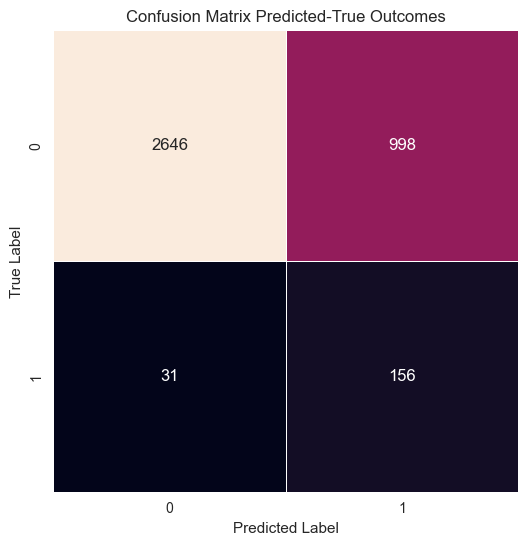

In [35]:
fig = plt.figure(figsize=((6, 6)))
plot.plot_confusion(confusion_matrix(y_train, rs_lr.predict(X_train)))

In [36]:
print(classification_report(y_test, rs_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1216
           1       0.12      0.79      0.22        62

    accuracy                           0.72      1278
   macro avg       0.55      0.75      0.52      1278
weighted avg       0.94      0.72      0.80      1278



### Model evaluation

We will assemble instances of RandomForest, XGBoost and LightGBM classifiers, evaluate the feature importance using feature permutation importance. 

Parameter grids are set for each classifier with limitations set to reduce overfitting on the training set

#### Random forest classifier

In [37]:
pipe_rf = Pipeline(
    [("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

In [38]:
n_estimators = range(100, 1000, 100)
parameters = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__n_estimators": n_estimators,
    "classifier__max_features": ["log2", "sqrt"],
    "classifier__max_depth": [3, 5, 7],
    "classifier__min_samples_split": [2, 5, 10, 20],
    "classifier__min_samples_leaf": [2, 4, 6, 8],
    "classifier__bootstrap": [True, False],
}

rs_rf = RandomizedSearchCV(
    pipe_rf, parameters, n_jobs=-1, random_state=random_state, scoring=scoring
).fit(X_train, y_train)

In [39]:
rs_rf.best_params_

{'preprocessor__num__imputer__strategy': 'mean',
 'classifier__n_estimators': 900,
 'classifier__min_samples_split': 5,
 'classifier__min_samples_leaf': 6,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 3,
 'classifier__bootstrap': True}

To investigate feature importance we will utilize feature permutations technique with 10 repeated fits on the validation portion of the dataset. Using permutations will reduce the bias towards numerical and high cardinality categorical features.

In [40]:
perm_importance = permutation_importance(
    rs_rf, X_train, y_train, n_repeats=10, random_state=random_state, n_jobs=-1
)

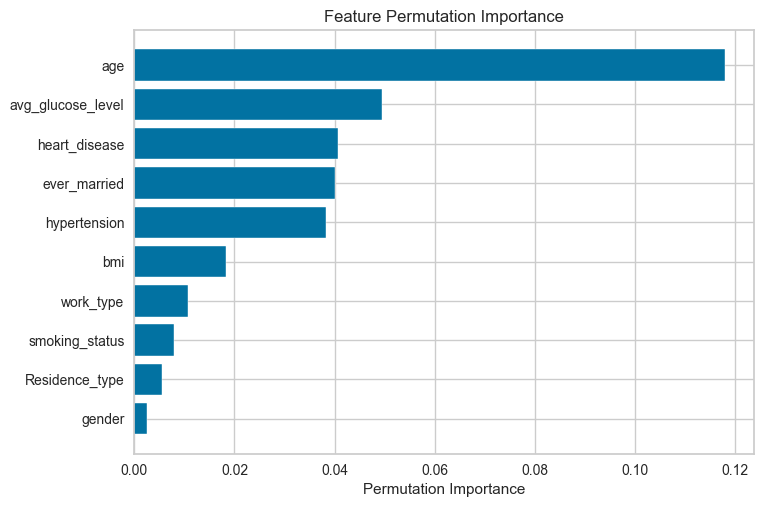

In [41]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Feature Permutation Importance")
plt.xlabel("Permutation Importance");

We can see that the scores for permutation importance on dataset features. Work type, Smoking status, Residence type and gender are on the low end of the feature importance spectrum. It is also worth noting that feature importance is following the same pattern as seen in the feature correlation analysis.

Since the assignment requirements state that model should be fit on all features, we will leave them all in.

#### XGBoost classifier

In [42]:
pipe_xg = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(scale_pos_weight=sum(y == 0) / sum(y == 1))),
    ]
)

In [43]:
params = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__n_estimators": [100, 200, 500, 750, 1000],
    "classifier__gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "classifier__min_child_weight": [1, 5, 10],
    "classifier__subsample": [0.5, 0.7, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 1.0],
}

In [44]:
rs_xg = RandomizedSearchCV(
    pipe_xg,
    params,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    random_state=random_state,
).fit(X_train, y_train)

In [45]:
rs_xg.best_params_

{'preprocessor__num__imputer__strategy': 'mean',
 'classifier__subsample': 0.7,
 'classifier__n_estimators': 750,
 'classifier__min_child_weight': 5,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.01,
 'classifier__gamma': 0.1,
 'classifier__colsample_bytree': 0.5}

#### LightGBM classifier

In [46]:
params = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__num_leaves": sp_randint(6, 50),
    "classifier__min_child_samples": sp_randint(100, 500),
    "classifier__min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    "classifier__subsample": sp_uniform(loc=0.2, scale=0.8),
    "classifier__colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
    "classifier__reg_alpha": [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    "classifier__reg_lambda": [0, 1e-1, 1, 5, 10, 20, 50, 100],
}

In [47]:
pipe_gbm = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(
                 is_unbalanced=True, verbose=-100,random_state=random_state
            ),
        ),
    ]
)

In [48]:
rs_gbm = RandomizedSearchCV(
    pipe_gbm,
    params,
    scoring=scoring,
    cv=5,
    random_state=random_state,
    n_jobs=-1,
).fit(X_train, y_train)

In [49]:
rs_gbm.best_params_

{'classifier__colsample_bytree': 0.7379729307073235,
 'classifier__min_child_samples': 364,
 'classifier__min_child_weight': 1,
 'classifier__num_leaves': 7,
 'classifier__reg_alpha': 2,
 'classifier__reg_lambda': 5,
 'classifier__subsample': 0.5521219949916811,
 'preprocessor__num__imputer__strategy': 'mean'}

And finally lets have a look how the different classifiers performed

In [50]:
tuned_scores = pd.DataFrame(
    {
        "Tuned_Avg_Precision": (
            rs_lr.best_score_,
            rs_rf.best_score_,
            rs_xg.best_score_,
            rs_gbm.best_score_,
        )
    },
    index=["Baseline", "Random Forest", "XGBoost", "LightGBM"],
)

In [51]:
tuned_scores

,Tuned_Avg_Precision
Baseline,0.182763
Random Forest,0.189137
XGBoost,0.205517
LightGBM,0.224973


LightGBM classifier performed the best with average precision of 0.22. This model will be picked for threshold tuning and final deployment

### Model evaluation and threshold tuning

To optimize the model for the particular case we can check the precision and recall scores and pick the decision threshold to be used by the model that maximizes the F1 score.

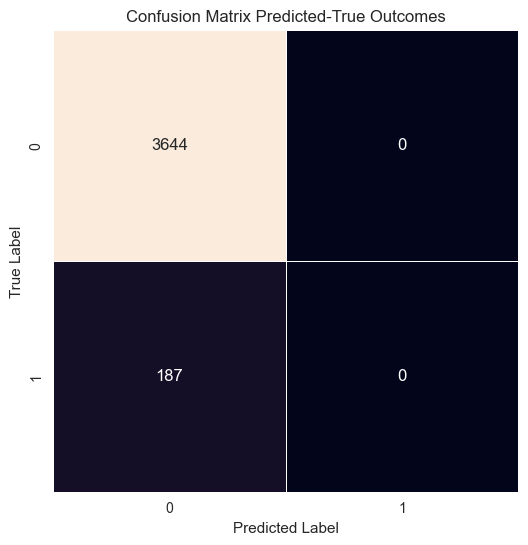

In [52]:
fig = plt.figure(figsize=((6, 6)))
plot.plot_confusion(confusion_matrix(y_train, rs_gbm.predict(X_train)))

Above confusion matrix visualizes our best tuned model prediction with the default 0.5 threshold for probability of feature label. As seen the model predicts majority class with only one True Positive prediction and one False Positive prediction. The concerning aspect is the False Negative errors we have. Since we want to predict the minority class label as accurately as we can and don't mind more False Positives predicted (being on the safe side of predicting a serious medical condition) we will adjust the prediction threshold of the model to minimize False Negatives at the expense of increasing False Positives.

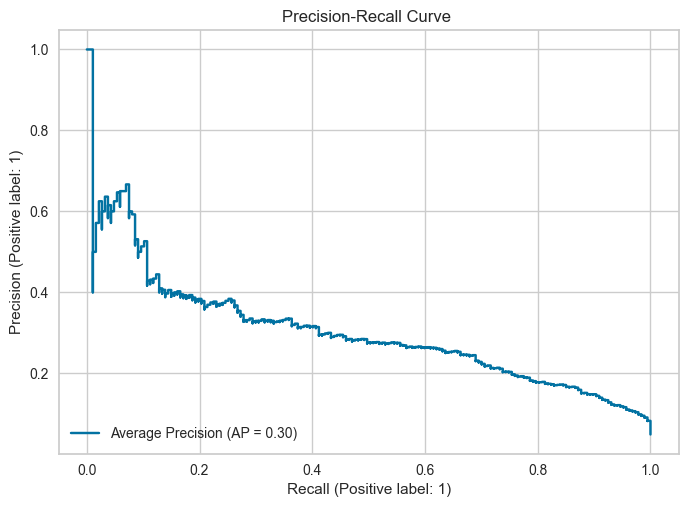

In [53]:
display = PrecisionRecallDisplay.from_estimator(
    rs_gbm, X_train, y_train, name="Average Precision"
)
display.ax_.set_title("Precision-Recall Curve ");

We see a dip or something that is called saw tooth pattern in the PR curve above. This usually happens when model is evaluating similar values and gets them all wrong or all correct thus locally reducing precision or recall depending on how the samples were classified.

Lets plot the metrics and let DiscriminationThreshold pick the best threshold value

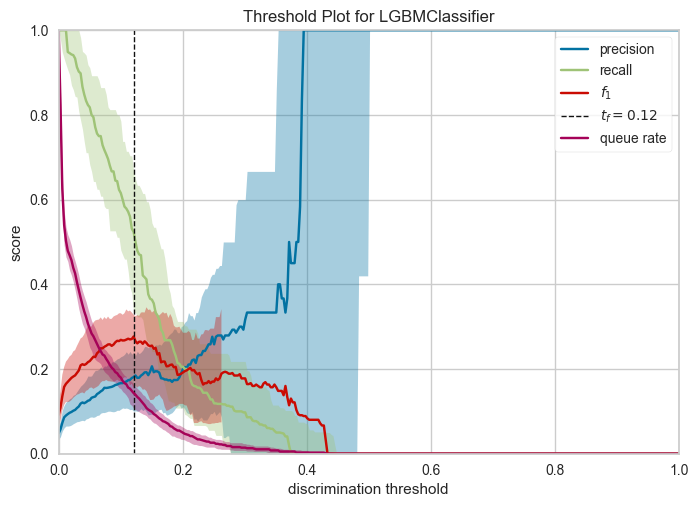

In [54]:
visualizer = DiscriminationThreshold(rs_gbm.best_estimator_)
visualizer.fit(X_train, y_train)
visualizer.show();

We can see the important metrics visualized against a set of thresholds with the best threshold identified - place in the plot where the F1 score is max.
We can now wrap the threshold value into the new pipeline for the final model

In [55]:
best_thresh = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]

In [56]:
pipe = Thresholder(rs_gbm, best_thresh, refit=False)
pipe.fit(X_train, y_train)

Thresholder(model=RandomizedSearchCV(cv=5,
                                     estimator=Pipeline(steps=[('preprocessor',
                                                                ColumnTransformer(transformers=[('num',
                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                  SimpleImputer()),
                                                                                                                 ('scaler',
                                                                                                                  StandardScaler())]),
                                                                                                 ['age',
                                                                                                  'avg_glucose_level',
                                                                                                  'bmi']),
                                                                                                ('cat',
                                                                                                 Pipeline(steps=[('encoder',
                                                                                                                  OneHotEncoder())]),
                                                                                                 ['gender',
                                                                                                  'hypertension',
                                                                                                  'heart_disease',
                                                                                                  'ever_married',
                                                                                                  'work_typ...
                                                          'classifier__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000228CE7B1D90>,
                                                          'classifier__reg_alpha': [0,
                                                                                    0.1,
                                                                                    1,
                                                                                    2,
                                                                                    5,
                                                                                    7,
                                                                                    10,
                                                                                    50,
                                                                                    100],
                                                          'classifier__reg_lambda': [0,
                                                                                     0.1,
                                                                                     1,
                                                                                     5,
                                                                                     10,
                                                                                     20,
                                                                                     50,
                                                                                     100],
                                                          'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000228CE8E9090>,
                                                          'preprocessor__num__imputer__strategy': ['mean',
                                                     

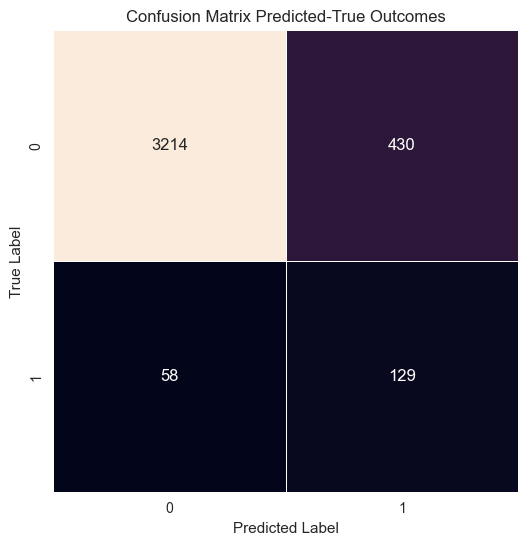

In [57]:
fig = plt.figure(figsize=((6, 6)))
plot.plot_confusion(confusion_matrix(y_train, pipe.predict(X_train)))

With the threshold adjusted we can see the reduction in False Negatives and increase in True Positives all at the expense of False Positives (recall). We can also have a look a the classification report for the adjusted model

In [58]:
print(classification_report(y_train, pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3644
           1       0.23      0.69      0.35       187

    accuracy                           0.87      3831
   macro avg       0.61      0.79      0.64      3831
weighted avg       0.95      0.87      0.90      3831



Looking at the label we are trying to predict '1' we can see that the model achieved a recall of 0.82 and precision of 0.17 which is lower than the average precision that we got while tuning the hyperparameters, but taking into account the severity of making False Negative predictions in this particular case, we had to sacrifice some of the precision.

### Model explanation

To get a better appreciation on how the model made the predictions and which features contributed to particular predictions the most we will analyze the LightGBM model using SHAP library. 
To use SHAP some manipulation of feature names and pipeline components is needed, this will allow for easier representation of features.

In [59]:
shap.initjs()

In [60]:
preprocessor = rs_gbm.best_estimator_.named_steps["preprocessor"]

In [61]:
ohe_categories = preprocessor.named_transformers_["cat"][0].categories_

In [62]:
new_ohe_features = [
    f"{col}__{val}"
    for col, vals in zip(categorical_clm, ohe_categories)
    for val in vals
]
all_features = numerical_clm + new_ohe_features

With feature names out of encoder we can create the SHAP model now

In [63]:
explainer = shap.TreeExplainer(rs_gbm.best_estimator_["classifier"])

In [64]:
observations = rs_gbm.best_estimator_["preprocessor"].transform(
    X_train.sample(1000, random_state=random_state)
)
shap_values = explainer.shap_values(observations)

We can look at one of the samples from the training set and observe feature importance on the prediction

In [65]:
i = 0
shap_values_i = shap_values[i][0]
shap.force_plot(
    explainer.expected_value[i],
    shap_values_i,
    features=observations[i],
    feature_names=all_features,
)

It seems that the model predicted correctly and we can observe that features who pushed the probability the most (colored in red) are numerical Age, BMI features and Ever Married categorical feature which has value 'No'

Next we will look at the summary plot, which cascades all model features and their impact on model prediction.

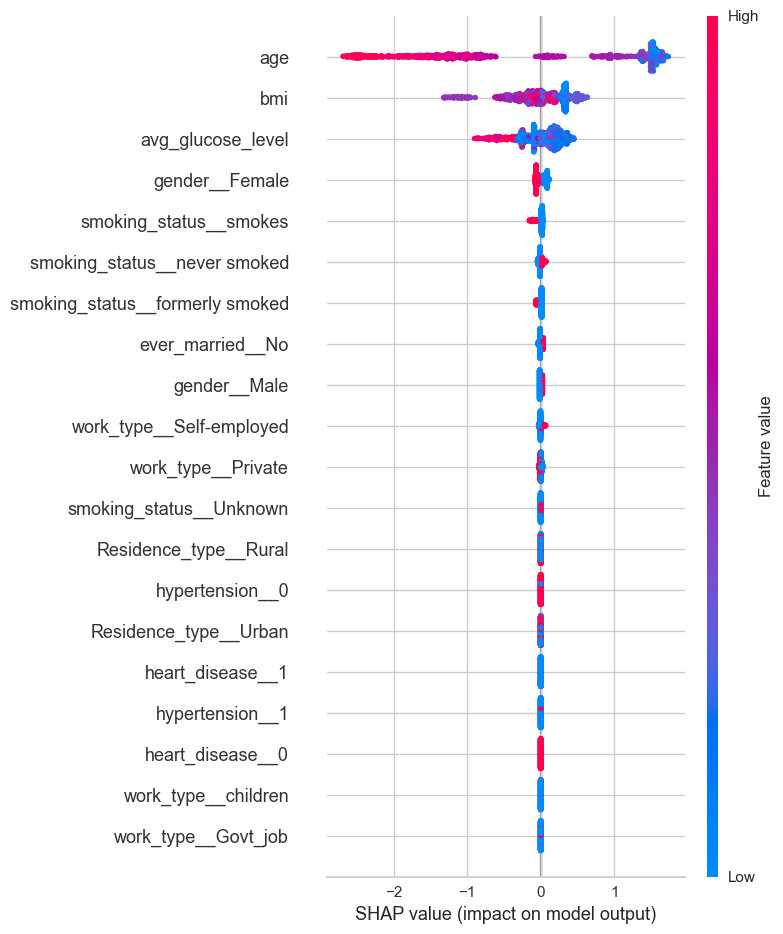

In [66]:
shap.summary_plot(shap_values[0], features=observations, feature_names=all_features)

Exploring the full set of features and their respective impact on model output we can see that most of the features do not have any sizeable impact on model output. The only features with any observable deviation from zero axis are Age, BMI, Average Glucose Level and negative values of Ever Married.

## Model test 

To finish off we can finally test the tuned model on the test dataset and evaluate the scores

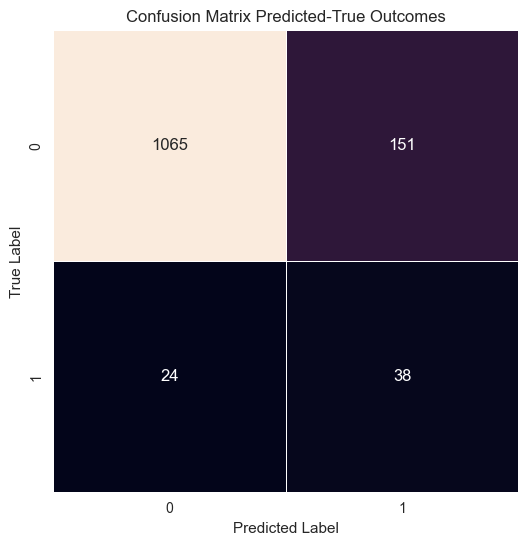

In [67]:
fig = plt.figure(figsize=((6, 6)))
plot.plot_confusion(confusion_matrix(y_test, pipe.predict(X_test)))

In [68]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92      1216
           1       0.20      0.61      0.30        62

    accuracy                           0.86      1278
   macro avg       0.59      0.74      0.61      1278
weighted avg       0.94      0.86      0.89      1278



## Conclusions

Several binary classifiers for stroke prediction were modeled, tuned and tested. LightGBM classifier was chosen as best performing using Average Precision as main metric, prediction threshold was then adjusted for best F1 score.

Following performance of models were observed:

- Base Logistic Regression model metrics for positive 'stroke' label on test dataset: Precision-__0.12__ , Recall-__0.79__

- LightGBM classification model metrics for positive 'stroke' label on __train__ dataset: Precision-__0.22__ , Recall-__0.72__

- LightGBM classification model metrics for positive 'stroke' label on __test__ dataset: Precision-__0.19__ , Recall-__0.63__

Some overfitting is present looking at the train and test dataset scores, this could be managed by limiting parameter grid of the model.

Model interpretation analysis revealed that many features have a very small impact on model prediction and could be dropped for a lighter model version.

In real life scenario the threshold value for model predictions would be set by business based on domain knowledge and business capacity (for example how many patients could possibly be checked further once identified with positive stroke label) for the learning exercise the threshold was set to an optimum value, in this case max F1.

The model performance is not the greatest, this can be explained with limited actual medical history/metrics features, undefined categorical features which can autocorrelate as explained in correlation analysis. 

## Future imporvements 

- Transform the features by scientifically proven nominal bins (obese/overweight etc for particular age groups)
- Separate data preprocessing pipeline from the classifier for easier control and load management
- Utilize another hold out dataset for validation and model explainability/debugging tasks
- Create a feature to signal risk/presence of diabetes by avg_glucose_level. More information on data is required for this particular ordeal
- Use Optuna or other hyperparameter tuning libraries for boosted model tuning
- Try and utilize undersampling/oversampling techniques to balance out the dataset for better class representation in model training
- Model training evaluation graphs to spot overfitting